# **NOAA Workshop - Rainfall Skill Explorer**
**Training Guide for KMD, UNMA, and Meteo Rwanda**

**Workshop Title:** Rainfall Product Skill Assessment & Flood Case Studies
**Duration:** ~2 hours (hands-on session)
**Notebook:** `NOAA_Rainfall_Skill_Explorer_v2.ipynb`

#### **1. Objectives**

By completing this exercise, you will:
* Learn how to use the Rainfall Skill Explorer Jupyter Notebook to evaluate multiple rainfall products.
* Assess the skill, bias, and reliability of CHIRPS, TAMSAT, IMERG, and ERA5 against validated ground stations.
* Explore long-term rainfall trends (2014-2024) in your country's capital.
* Analyze how each dataset captured severe flood events in Kenya, Uganda, and Rwanda.
* Discuss operational implications for early warning, forecasting, and product selection.

#### **2. Dataset Overview**

| Category | Dataset | Source | Spatial Resolution | Temporal Coverage | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Ground Observations** | TAHMO / National Met Stations | Met agencies | Point | Daily | High-confidence QC from Notebook 1 |
| **Satellite Products** | CHIRPS | UCSB/ FEWS NET | $0.05^{\circ}$ (~5 km) | 1981-present | May underestimate convective extremes |
| | TAMSAT | University of Reading | 0.0375° (~4 km) | 1983-present | Strong climatology, may miss isolated storms |
| | IMERG (GPM) | NASA | 0.1° (~10 km) | 2000-present | Good detection of extremes, higher variance |
| **Reanalysis** | ERA5 | ECMWF | 0.25° (~25 km) | 1979-present | Smooth but underestimates short bursts |

#### **3. Notebook Key steps**
- Step 1: Load datasets (Ground and Satellite)
- Step 2: Load helper functions
- Step 3: Prepare ground data
- Step 4: Long term precipitation trends and climatology
- Step 5: Aggregation of Station data to match CHIRPS 5-day (pentads) data
- Step 6: Build Nearest data for the high confidence ground stations
- Step 7: Compute station scores
- Step 8: Visualize Station Scores Across Datasets


#### **4. Case Study Contexts**

##### 4.1 Kenya – Mai Mahiu Flash Flood (Nakuru County)
* **Date:** 29 April 2024 * **Window:** 20 April - 5 May 2024

##### 4.2 Uganda - Mbale-Kapchorwa Floods (Eastern Region)
* **Date:** 30 July 2022 * **Window:** 28 July - 2 August 2022

##### 4.3 Rwanda – Western & Northern Provinces Floods
* **Date:** 2 May 2023 * **Window:** 1 May - 8 May 2023


#### **5. Outputs**
Each team should produce PNG figures and CSV outputs, which will be saved in the `Results_SkillExplorer_<country>_<date>` folder.

#### **6. Interpretation Template (for group reporting)**

| Country | Station / Event | Best Performing Product | Main Finding | Operational Implication |
| :--- | :--- | :--- | :--- | :--- |
| **Kenya** | KE-012 Mai Mahiu (2024) | IMERG | Best extreme detection; CHIRPS underestimates | Combine IMERG for flood alerting + ERA5 for background context |
| **Uganda** | UG-00456 Mbale-Kapchorwa (2022) | ERA5 | Consistent timing; TAMSAT misses short bursts | ERA5 captures system-scale but misses extremes |
| **Rwanda** | RW-00789 Western Floods (2023) | TAMSAT | Good match to ground totals; ERA5 underestimates | Regional bias correction could improve early warnings |


**Audience:** KMD, UNMA, Meteo Rwanda  

In [44]:
# @title Step 1: Load datasets (Ground and Satellite) {"display-mode":"both"}

# 💡 This step loads previously downloaded datasets: TAHMO(Ground), CHIRPS, IMERG, TAMSAT, ERA5

import os, numpy as np, pandas as pd
from datetime import date
from google.colab import drive
drive.mount('/content/drive')
# Set the environment path to the shared drive folder
shared_drive_path = '/content/drive/Shared drives/NOAA-workshop2/Datasets' # Path to datafiles


# Set capital coordinates
CAPITALS={'Kenya':{'name':'Nairobi','lat':-1.2921,'lon':36.8219},
          'Uganda':{'name':'Kampala','lat':0.3476,'lon':32.5825},
          'Rwanda':{'name':'Kigali','lat':-1.9579,'lon':30.1127}}

# Select country
COUNTRY = 'Kenya'

# Set data to be used
Satellite_data_options = ['CHIRPS', 'TAMSAT', 'IMERG', 'ERA5'] # Datasets to be used in the analysis (TAMSAT, IMERG, ERA5, CHIRPS)

# Set high confidence stations
High_confidence_stations = ['TA00247', 'TA00453', 'TA00379'] # Define top stations here, use 'none' if there is no preference
                                                  # For testing purposes: Kenya list: ['TA00247', 'TA00453', 'TA00379']
                                                    #                     Uganda list: ['TA00234', 'TA00446', 'TA00208']
                                                    #                     Rwanda list: ['TA00451', 'TA00429', 'TA00326']

# Set the names of the data sources as saved in the shared drive path
GROUND_CSV=f'./tahmo_precip_2014-01-01_2024-12-31_{COUNTRY}.csv';
CHIRPS_NC=f'./CHIRPS_2014-01-01_2024-12-31_{COUNTRY}.nc';
TAMSAT_NC=f'./TAMSAT_precip_2014-01-01_2024-12-31_{COUNTRY}.nc';
IMERG_NC=f'./IMERG_2014-01-01_2024-12-27_{COUNTRY}.nc';
ERA5_NC=f'./ERA5_precip_2014-01-01_2024-12-31_{COUNTRY}.nc'

# Set start and end date
START_DATE='2014-01-01'; END_DATE='2024-12-31'; LTN_BASE=('2014-01-01','2024-12-31')

# Set QC metrics
NEIGHBORHOOD=5; # Define neighborhood size
EXTREME_THRESHOLDS=[20,50,100];
CORR_METHOD='pearson'

# Set events with approximate coordinates
EVENTS = {
    'Kenya – Mai Mahiu flash flood (2024-04-29)': {
        'dates': ('2024-04-20', '2024-05-05'),
        'coords': (-1.039, 36.606)   # Mai Mahiu, Nakuru County, Kenya
    },
    'Uganda – Mbale–Kapchorwa floods (2022-07-30)': {
        'dates': ('2022-07-28', '2022-08-02'),
        'coords': (1.082, 34.175)    # Mbale town, Eastern Uganda
    },
    'Rwanda – Western/Northern floods (2023-05-02)': {
        'dates': ('2023-05-01', '2023-05-08'),
        'coords': (-1.680, 29.350)   # Between Rubavu & Nyabihu districts, Rwanda
    }
}
Radius_event = 30 # radius in km to consider for visual

# --------------------------------------------------------------------------------------
os.chdir(os.path.join(shared_drive_path, COUNTRY)) # set working directory to country sub folder
print(f"Working directory set to: {os.getcwd()}")
RUN_STAMP=date.today().isoformat(); RESULTS_DIR=f'/content/drive/MyDrive/Results_SkillExplorer_{COUNTRY}_{RUN_STAMP}'; os.makedirs(RESULTS_DIR, exist_ok=True); np.random.seed(42)
print('✅ CONFIG set →', RESULTS_DIR)

# Check if data files exist
data_files = [GROUND_CSV, CHIRPS_NC, TAMSAT_NC, IMERG_NC, ERA5_NC]

print("Checking for data files:")
for data_file_var in data_files:
    if os.path.exists(data_file_var):
        print(f"✅ {data_file_var} found.")
    else:
        print(f"❌ {data_file_var} not found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: /content/drive/Shared drives/NOAA-workshop2/Datasets/Kenya
✅ CONFIG set → /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16
Checking for data files:
✅ ./tahmo_precip_2014-01-01_2024-12-31_Kenya.csv found.
✅ ./CHIRPS_2014-01-01_2024-12-31_Kenya.nc found.
✅ ./TAMSAT_precip_2014-01-01_2024-12-31_Kenya.nc found.
✅ ./IMERG_2014-01-01_2024-12-27_Kenya.nc found.
✅ ./ERA5_precip_2014-01-01_2024-12-31_Kenya.nc found.


In [45]:
# @title Step 2: Load helper functions {"display-mode":"form"}

# @markdown This cell defines several helper functions that are used later in the notebook for data processing and analysis.

# @markdown These include code extract timeseries, calculate sums etc.

# 2) HELPERS
import numpy as np, pandas as pd, os
def load_ground(p):
    if not os.path.exists(p): print('⚠️ Ground CSV not found:', p); return None
    df=pd.read_csv(p,parse_dates=['date']); req={'station_id','date','precip','lat','lon'}; miss=req-set(df.columns)
    if miss: print('⚠️ Missing cols:',miss); return None
    if 'high_confidence' in df.columns: df=df[df['high_confidence']==True].copy()
    return df
def open_nc(p):
    try:
        import xarray as xr
        return xr.open_dataset(p) if os.path.exists(p) else None
    except Exception as e: print('ℹ️ xarray error:', e); return None
def _near(arr,val):
    arr=np.asarray(arr); return int(np.argmin(np.abs(arr-val)))
def extract_timeseries(ds,lat,lon,k=1):
    if ds is None: return None
    import pandas as pd
    var=list(ds.data_vars)[0] if ds.data_vars else None
    if var is None: return None

    # Check for 'lat'/'lon' or 'y'/'x' dimensions
    if 'lat' in ds.coords and 'lon' in ds.coords:
        lats = ds['lat'].values
        lons = ds['lon'].values
        lat_dim, lon_dim = 'lat', 'lon'
    elif 'y' in ds.coords and 'x' in ds.coords:
        lats = ds['y'].values
        lons = ds['x'].values
        lat_dim, lon_dim = 'y', 'x'
    else:
        print(f"⚠️ Could not find 'lat'/'lon' or 'y'/'x' dimensions in dataset.")
        return None

    da=ds[var]
    lon_w=lon if not(lons.min()>=0 and lons.max()>180 and lon<0) else lon%360.0
    i=_near(lats,lat); j=_near(lons,lon_w)

    if k==1:
        sub=da.isel({lat_dim:i, lon_dim:j})
    else:
        sub=da.isel({lat_dim:slice(max(i-k//2,0),i+k//2+1), lon_dim:slice(max(j-k//2,0),j+k//2+1)}).mean(dim=[lat_dim,lon_dim],skipna=True)

    try: ts=sub.to_series()
    except Exception: ts=pd.Series(sub.values,index=pd.to_datetime(ds['time'].values))
    if ts.dropna().quantile(0.99)<1.0: ts=ts*1000.0
    return ts
def monthly_sum(ts):
    return None if ts is None or ts.empty else ts.resample('MS').sum(min_count=1)
def mann_kendall(ms):
    s=ms.dropna().values; n=len(s)
    if n<8: return {'slope':np.nan,'p':np.nan,'direction':'insufficient'}
    S=0
    for i in range(n-1): S+=np.sum(np.sign(s[i+1:]-s[i]))
    varS=(n*(n-1)*(2*n+5))/18.0
    z=(S-1)/np.sqrt(varS) if S>0 else ((S+1)/np.sqrt(varS) if S<0 else 0.0)
    from math import erf, sqrt; Phi=lambda z:0.5*(1.0+erf(z/np.sqrt(2.0))); p=2*(1-Phi(abs(z)))
    x=np.arange(n); slopes=[]
    for i in range(n-1): dx=(x[i+1:]-x[i]); dy=(s[i+1:]-s[i]); slopes+=list(dy/dx)
    slope=float(np.median(slopes)); direction='increasing' if slope>0 and p<0.05 else ('decreasing' if slope<0 and p<0.05 else 'no_significant_trend')
    return {'slope':slope,'p':float(p),'direction':direction}
def metrics(gt,mod,ths):
    df=pd.concat([gt.rename('gt'),mod.rename('mod')],axis=1).dropna()
    if df.empty: return None
    rmse=float(np.sqrt(((df['mod']-df['gt'])**2).mean())); bias=float((df['mod']-df['gt']).abs().mean())
    cp=df.corr(method='pearson').iloc[0,1]; cs=df.corr(method='spearman').iloc[0,1]
    hits={}
    for th in ths:
        gt_hit=df['gt']>=th; mod_hit=df['mod']>=th; denom=int(gt_hit.sum()); hits[f'hitrate_{th}mm']=float((gt_hit&mod_hit).sum()/denom) if denom>0 else np.nan
    return {'rmse':rmse,'bias':bias,'corr_pearson':float(cp),'corr_spearman':float(cs),**hits}

print("✅ Helper functions loaded successfully")

✅ Helper functions loaded successfully


In [46]:
# @title Step 3: Prepare ground data {"display-mode":"form"}

# @markdown This step Loads and prepares ground truth data from time series and metadata CSV files.
# 3) LOAD
import pandas as pd

def load_ground_from_files(time_series_path, metadata_path):
    """
    Loads and prepares ground truth data from time series and metadata CSV files.

    Args:
        time_series_path (str): Path to the time series CSV file.
        metadata_path (str): Path to the metadata CSV file.

    Returns:
        pandas.DataFrame: Processed ground truth data or None if files are not found or data is empty.
    """
    if not os.path.exists(time_series_path):
        print('⚠️ Ground time series CSV not found:', time_series_path)
        return None
    if not os.path.exists(metadata_path):
        print('⚠️ Ground metadata CSV not found:', metadata_path)
        return None

    df_ts = pd.read_csv(time_series_path, parse_dates=['date'])
    df_meta = pd.read_csv(metadata_path)

    if df_ts.empty or df_meta.empty:
        print('⚠️ Ground truth or metadata is empty.')
        return None

    # Reshape time series data
    df_melted = df_ts.melt(id_vars=['date'], var_name='station_id', value_name='precip').dropna(subset=['precip'])

    # Merge with metadata
    # Assuming the metadata station id column is named 'code' and location columns 'location.latitude', 'location.longitude'
    df_merged = pd.merge(df_melted, df_meta[['code', 'location.latitude', 'location.longitude']],
                         left_on='station_id', right_on='code', how='left')

    # Rename columns to match the expected format
    df_merged = df_merged.rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

    # Check for required columns after merging
    req = {'station_id', 'date', 'precip', 'lat', 'lon'}
    miss = req - set(df_merged.columns)
    if miss:
        print('⚠️ Missing required columns after merge:', miss)
        return None

    # Drop the redundant 'code' column
    df_merged = df_merged.drop(columns=['code'])

    # Convert START_DATE and END_DATE to timezone-aware datetime objects in UTC
    start_date_utc = pd.to_datetime(START_DATE, utc=True)
    end_date_utc = pd.to_datetime(END_DATE, utc=True)

    # Filter by date range using timezone-aware comparison
    df_processed = df_merged[(df_merged['date'] >= start_date_utc) & (df_merged['date'] <= end_date_utc)].copy()

    if 'high_confidence' in df_processed.columns:
        df_processed = df_processed[df_processed['high_confidence'] == True].copy()

    return df_processed

# Load ground truth data using the new function
metadata_csv = './tahmo_metadata.csv' # Assuming this is the path to the metadata file
df_gt = load_ground_from_files(GROUND_CSV, metadata_csv)


ds_chirps=open_nc(CHIRPS_NC); ds_tamsat=open_nc(TAMSAT_NC); ds_imerg=open_nc(IMERG_NC); ds_era5=open_nc(ERA5_NC)

if df_gt is not None:
    print('✅ Ground rows:',len(df_gt))
else:
    print('❌ Ground data could not be loaded.')

✅ Ground rows: 308464


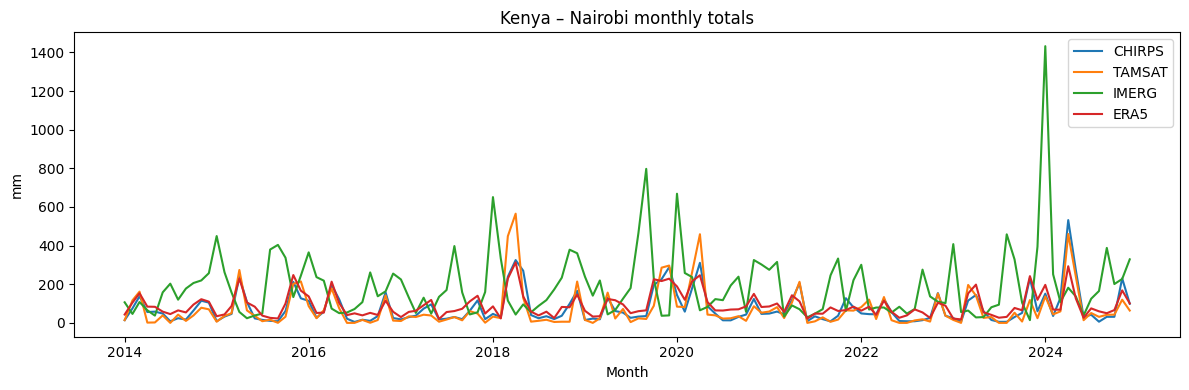

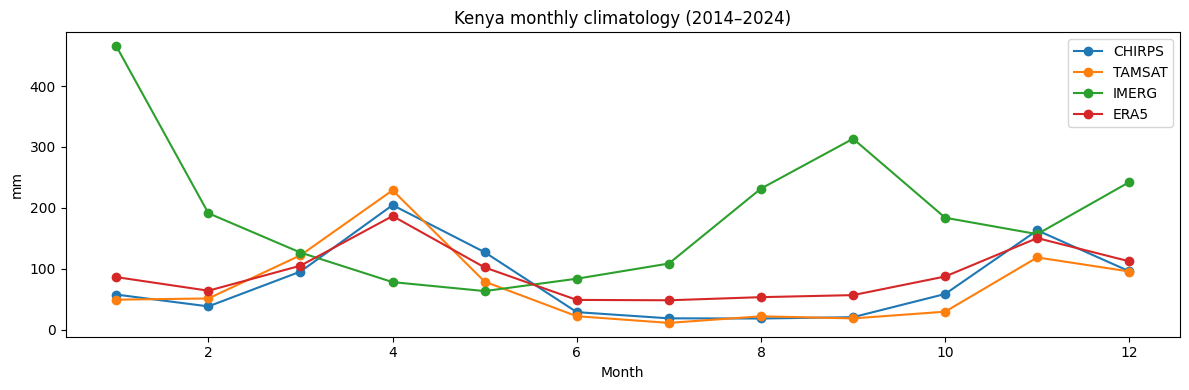

,dataset,slope,p,direction
0,CHIRPS,0.049076,0.593966,no_significant_trend
1,TAMSAT,0.082524,0.341046,no_significant_trend
2,IMERG,0.041635,0.854841,no_significant_trend
3,ERA5,0.017271,0.864112,no_significant_trend


- CHIRPS: slope=0.05 mm/mon, p=0.594, trend=no_significant_trend
- TAMSAT: slope=0.08 mm/mon, p=0.341, trend=no_significant_trend
- IMERG: slope=0.04 mm/mon, p=0.855, trend=no_significant_trend
- ERA5: slope=0.02 mm/mon, p=0.864, trend=no_significant_trend
✅ LTN exports saved


In [47]:
# @title Step 4: Long term precipitation trends and climatology {"display-mode":"form"}

# @markdown This section focuses on analyzing long-term monthly precipitation trends and climatology for the capital city of the country
# 5) LTN & TRENDS
import matplotlib.pyplot as plt, pandas as pd, os
cap=CAPITALS[COUNTRY]
series={}
# Iterate through the datasets specified in Satellite_data_options
for name in Satellite_data_options:
    ds = None
    if name == 'CHIRPS' and ds_chirps is not None:
        ds = ds_chirps
    elif name == 'TAMSAT' and ds_tamsat is not None:
        ds = ds_tamsat
    elif name == 'IMERG' and ds_imerg is not None:
        ds = ds_imerg
    elif name == 'ERA5' and ds_era5 is not None:
        ds = ds_era5

    if ds is not None:
        ts = extract_timeseries(ds, cap['lat'], cap['lon'], k=NEIGHBORHOOD)
        if ts is None:
            continue
        ts=ts[(ts.index>=pd.to_datetime(LTN_BASE[0]))&(ts.index<=pd.to_datetime(LTN_BASE[1]))]
        ms=monthly_sum(ts);
        if ms is not None: series[name]=ms

if series:
    fig=plt.figure(figsize=(12,4))
    for n,ms in series.items(): plt.plot(ms.index,ms.values,label=n)
    plt.title(f"{COUNTRY} – {cap['name']} monthly totals"); plt.ylabel('mm'); plt.xlabel('Month'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_monthly_{COUNTRY}.png")); plt.show()
    clims={n:ms.groupby(ms.index.month).mean() for n,ms in series.items()}
    fig=plt.figure(figsize=(12,4))
    for n,cl in clims.items(): plt.plot(range(1,13),cl.values,marker='o',label=n)
    plt.title(f"{COUNTRY} monthly climatology (2014–2024)"); plt.xlabel('Month'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_climatology_{COUNTRY}.png")); plt.show()
    rows=[{'dataset':n,**mann_kendall(ms)} for n,ms in series.items()]; df_trends=pd.DataFrame(rows); display(df_trends)
    df_trends.to_csv(os.path.join(RESULTS_DIR,f"ltn_trends_{COUNTRY}.csv"),index=False)
    for _,r in df_trends.iterrows(): print(f"- {r['dataset']}: slope={r['slope']:.2f} mm/mon, p={r['p']:.3f}, trend={r['direction']}")
    print('✅ LTN exports saved')
else:
    print('ℹ️ No LTN series available (check NetCDFs).')

In [48]:
# @title Step 5: Aggregation of Station data to match CHIRPS 5-day (pentads) data {"display-mode":"form"}
# @markdown This section aggregates the ground truth data to pentads for all available stations and saves the result to a CSV file and a DataFrame variable.

import matplotlib.pyplot as plt, os, pandas as pd, numpy as np

if df_gt is None or df_gt.empty:
    print('⚠️ Ground data not loaded or is empty. Cannot aggregate to pentads.')
else:
    # Filter df_gt to include only high confidence stations if specified
    if High_confidence_stations and High_confidence_stations != ['none']:
        available_high_confidence_stations = [station for station in High_confidence_stations if station in df_gt['station_id'].unique()]
        if available_high_confidence_stations:
            df_gt_filtered = df_gt[df_gt['station_id'].isin(available_high_confidence_stations)].copy()
            print(f"Aggregating data for high confidence stations: {available_high_confidence_stations}")
        else:
            print("⚠️ High confidence stations specified but none found in ground data. Aggregating all stations.")
            df_gt_filtered = df_gt.copy() # Use all data if specified stations are not found
    else:
        print("Aggregating data for all stations.")
        df_gt_filtered = df_gt.copy() # Use all data if no high confidence stations are specified

    # Filter by start and end date
    df_gt_filtered = df_gt_filtered[(df_gt_filtered['date'] >= pd.to_datetime(START_DATE, utc=True)) & (df_gt_filtered['date'] <= pd.to_datetime(END_DATE, utc=True))].copy()


    # Pivot the filtered ground truth data to have stations as columns and date as index
    ground_truth_pentad = df_gt_filtered.pivot_table(index='date', columns='station_id', values='precip').resample('5D').sum()

    if not ground_truth_pentad.empty:
        # Save the pentad data to a CSV file
        pentad_output_path = os.path.join(RESULTS_DIR, f'ground_truth_pentads_{COUNTRY}.csv')
        ground_truth_pentad.to_csv(pentad_output_path)
        print(f"✅ Ground truth pentad data saved to {pentad_output_path}")

        # Store the pentad data in a new variable for later use
        ground_truth_pentads_df = ground_truth_pentad
        print("✅ Ground truth pentad data stored in 'ground_truth_pentads_df' variable.")
        display(ground_truth_pentads_df.head()) # Display the head of the new DataFrame
    else:
        print('⚠️ Ground truth pentad DataFrame is empty after aggregation.')

Aggregating data for high confidence stations: ['TA00247', 'TA00453', 'TA00379']
✅ Ground truth pentad data saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/ground_truth_pentads_Kenya.csv
✅ Ground truth pentad data stored in 'ground_truth_pentads_df' variable.


station_id,TA00247,TA00379,TA00453
date,,,
2017-09-27 00:00:00+00:00,1.685,0.0,0.0
2017-10-02 00:00:00+00:00,0.102,0.0,0.0
2017-10-07 00:00:00+00:00,0.681,0.0,0.0
2017-10-12 00:00:00+00:00,68.426,0.0,0.0
2017-10-17 00:00:00+00:00,85.984,0.0,0.0


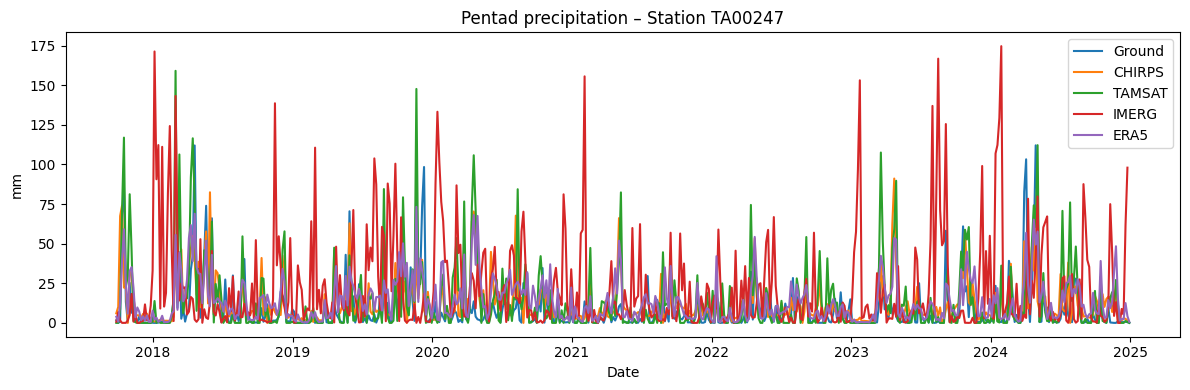

In [49]:
# @title Step 6: Build Nearest data for the high confidence ground stations
# @markdown At this step we are building the station dataset by using the station metadata (latitude and longitude) to get the nearest value for each selected satellite product


# Make station_datasets a global variable
global station_datasets

# filter to the required stations (high confidence stations)
# req_stations = region_precip_pentad.columns.tolist() # This line seems unnecessary here as we are using High_confidence_stations

# region_metadata = region_metadata[region_metadata['code'].isin(req_stations)] # This line seems unnecessary here

def build_chirps_from_stations(chirps_ds, stations_metadata, k=NEIGHBORHOOD):
    """
    Build CHIRPS station dataset by sampling CHIRPS values at station locations.

    Parameters
    ----------
    chirps_ds : xarray.Dataset
        CHIRPS dataset with coordinates ('x', 'y', 'time')
    stations_metadata : pd.DataFrame
        Must contain columns ['code', 'lat', 'lon']
    k : int, optional
        Number of nearest CHIRPS grid points to average. Default is 1 (just nearest pixel).
    """
    import numpy as np
    import pandas as pd

    all_stations_data = {}

    # Extract coordinate arrays for CHIRPS grid
    chirps_lons = chirps_ds['x'].values
    chirps_lats = chirps_ds['y'].values

    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Compute distances (simple Euclidean approximation — fine for small areas)
        dist = np.sqrt((chirps_lats[:, None] - lat)**2 + (chirps_lons[None, :] - lon)**2)
        dist_flat = dist.ravel()

        # Get the k nearest pixel indices
        nearest_indices = np.argsort(dist_flat)[:k]

        # Convert flat indices back to 2D (lat, lon)
        lat_idx, lon_idx = np.unravel_index(nearest_indices, dist.shape)

        # Extract data for those k pixels
        da_values = [chirps_ds.precipitation.isel(y=lat_i, x=lon_i) for lat_i, lon_i in zip(lat_idx, lon_idx)]

        # Compute mean across k nearest points
        station_da = sum(da_values) / len(da_values)
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    combined_df = pd.DataFrame(all_stations_data)
    return combined_df


# Define a function to build station datasets from any grid dataset
def build_station_dataset_from_grid(grid_ds, stations_metadata, k=NEIGHBORHOOD):
    """
    Build station dataset by sampling grid values at station locations.

    Parameters
    ----------
    grid_ds : xarray.Dataset
        Grid dataset with precipitation data. Assumes time, lat, lon dimensions.
    stations_metadata : pd.DataFrame
        Must contain columns ['code', 'location.latitude', 'location.longitude']
    k : int, optional
        Number of nearest grid points to average. Default is 1 (just nearest pixel).
    """
    if grid_ds is None:
        return None

    import numpy as np
    import pandas as pd

    all_stations_data = {}

    # Check for 'lat'/'lon' or 'y'/'x' dimensions
    if 'lat' in grid_ds.coords and 'lon' in grid_ds.coords:
        grid_lats = grid_ds['lat'].values
        grid_lons = grid_ds['lon'].values
        lat_dim, lon_dim = 'lat', 'lon'
    elif 'y' in grid_ds.coords and 'x' in grid_ds.coords:
        grid_lats = grid_ds['y'].values
        grid_lons = grid_ds['x'].values
        lat_dim, lon_dim = 'y', 'x'
    else:
        print(f"⚠️ Could not find 'lat'/'lon' or 'y'/'x' dimensions in dataset.")
        return None

    # Find the precipitation variable name
    precip_var = None
    for var in grid_ds.data_vars:
        # Look for common precipitation variable names and dimensions
        if 'precip' in var.lower() or 'rainfall' in var.lower() or 'precipitation' in var.lower() or 'rfe' in var.lower():
             if (lat_dim in grid_ds[var].dims and lon_dim in grid_ds[var].dims and 'time' in grid_ds[var].dims):
                 precip_var = var
                 break

    if precip_var is None:
        print(f"⚠️ Could not find a precipitation variable in the dataset.")
        return None


    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        # Access lat and lon using the correct column names from the metadata
        lat = row['location.latitude']
        lon = row['location.longitude']

        # Find the nearest grid point(s)
        # This is a simplified approach, more accurate methods might be needed for complex grids
        lat_idx = np.abs(grid_lats - lat).argmin()
        lon_idx = np.abs(grid_lons - lon).argmin()

        if k == 1:
            # Extract data for the single nearest pixel
            station_da = grid_ds[precip_var].isel({lat_dim: lat_idx, lon_dim: lon_idx})
        else:
            # Extract data for k nearest points and compute mean
            # This is a basic implementation, a more sophisticated approach might involve distance weighting
            lat_slice = slice(max(lat_idx - k // 2, 0), min(lat_idx + k // 2 + 1, len(grid_lats)))
            lon_slice = slice(max(lon_idx - k // 2, 0), min(lon_idx + k // 2 + 1, len(grid_lons)))

            sub = grid_ds[precip_var].isel({lat_dim: lat_slice, lon_dim: lon_slice})

            # Handle potential empty slices if k is too large near edges
            if sub[lat_dim].size == 0 or sub[lon_dim].size == 0:
                 print(f"⚠️ Skipping station {station_code}: Could not extract data for {k} nearest points near grid edge.")
                 all_stations_data[station_code] = pd.Series(dtype=float) # Add an empty series for this station
                 continue


            station_da = sub.mean(dim=[lat_dim, lon_dim], skipna=True)


        # Convert xarray DataArray to pandas Series and rename
        try:
            station_series = station_da.to_series()
            station_series.name = station_code
            all_stations_data[station_code] = station_series
        except Exception as e:
             print(f"Error converting xarray to series for station {station_code}: {e}")
             all_stations_data[station_code] = pd.Series(dtype=float) # Add an empty series in case of error


    # Combine all station series into a single DataFrame
    # Use concat with join='outer' to handle potential missing dates in individual series
    combined_df = pd.concat(all_stations_data.values(), axis=1, keys=all_stations_data.keys())
    return combined_df


# This function is now redundant as build_station_dataset_from_grid handles all datasets
# chirps_stations = build_chirps_from_stations(chirps_ds, region_metadata)
# plot_stations_data_randomly(chirps_stations)
# chirps_stations

# --- Extract Daily Station Data for all Satellite Datasets ---
station_datasets = {} # Initialize the dictionary

# Assuming df_meta is available from Step 3 or similar metadata loading
# If not, reload it
if 'df_meta' not in locals() or df_meta.empty:
    metadata_csv = './tahmo_metadata.csv' # Assuming this is the path to the metadata file
    if os.path.exists(metadata_csv):
        df_meta = pd.read_csv(metadata_csv)
        print("Reloaded ground truth metadata.")
    else:
        print(f"⚠️ Ground metadata CSV not found at {metadata_csv}. Cannot extract daily station data from satellite products.")
        df_meta = pd.DataFrame() # Set to empty DataFrame to prevent errors

if High_confidence_stations and High_confidence_stations != ['none'] and not df_meta.empty:
     available_high_confidence_stations_meta = df_meta[df_meta['code'].isin(High_confidence_stations)].copy()
     # Rename latitude and longitude columns to 'lat' and 'lon'
     # This renaming is not needed inside the function anymore but keeping it here doesn't hurt
     # available_high_confidence_stations_meta = available_high_confidence_stations_meta.rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

     if not available_high_confidence_stations_meta.empty:
         print("Extracting daily data for high confidence stations from satellite products...")
         # Iterate through the satellite datasets and extract daily data for each station
         for dataset_name in Satellite_data_options:
             print(f"Processing {dataset_name}...")
             if dataset_name == 'CHIRPS' and ds_chirps is not None:
                 # Use the specific CHIRPS function if needed, or adapt the generic one
                 # For now, let's use the generic one for consistency
                 station_datasets[dataset_name] = build_station_dataset_from_grid(ds_chirps, available_high_confidence_stations_meta, k=NEIGHBORHOOD)
             elif dataset_name == 'TAMSAT' and ds_tamsat is not None:
                 station_datasets[dataset_name] = build_station_dataset_from_grid(ds_tamsat, available_high_confidence_stations_meta, k=NEIGHBORHOOD)
             elif dataset_name == 'IMERG' and ds_imerg is not None:
                  station_datasets[dataset_name] = build_station_dataset_from_grid(ds_imerg, available_high_confidence_stations_meta, k=NEIGHBORHOOD)
             elif dataset_name == 'ERA5' and ds_era5 is not None:
                 station_datasets[dataset_name] = build_station_dataset_from_grid(ds_era5, available_high_confidence_stations_meta, k=NEIGHBORHOOD)
             else:
                 print(f"ℹ️ Skipping {dataset_name}: Dataset not loaded or available.")

             if dataset_name in station_datasets and station_datasets[dataset_name] is not None and not station_datasets[dataset_name].empty:
                 print(f"✅ Daily station data extracted for {dataset_name}.")
                 # display(station_datasets[dataset_name].head()) # Optional: display head of extracted data
             else:
                 print(f"⚠️ No daily station data extracted for {dataset_name}.")

     else:
         print("⚠️ High confidence stations metadata not found. Cannot extract daily station data from satellite products.")
else:
     print("⚠️ Ground data or metadata not loaded, is empty, or no high confidence stations specified. Cannot extract daily station data from satellite products.")


# --- Aggregate to Pentads ---
# Assuming station_datasets is available from Step 9
if 'station_datasets' in globals() and station_datasets:
    pentad_station_datasets = {}
    # Set the origin for resampling to the START_DATE
    origin_date = pd.to_datetime(START_DATE, utc=True)
    for dataset_name, daily_df in station_datasets.items():
        if daily_df is not None and not daily_df.empty:
            print(f"Aggregating {dataset_name} to pentads...")
            # Ensure the index of daily_df is timezone-aware (UTC) before resampling
            if daily_df.index.tzinfo is None:
                daily_df = daily_df.tz_localize('UTC')
            elif daily_df.index.tzinfo != origin_date.tzinfo:
                 daily_df = daily_df.tz_convert(origin_date.tzinfo)

            # Resample to 5-day periods and sum, setting the origin to START_DATE
            pentad_df = daily_df.resample('5D', origin=origin_date).sum()
            pentad_station_datasets[dataset_name] = pentad_df
            print(f"✅ {dataset_name} aggregated to pentads.")
            # print(f"\nHead of {dataset_name} pentad data:")
            # display(pentad_df.head())
        else:
            print(f"ℹ️ Skipping {dataset_name}: Daily station data not available or is empty.")
else:
    print("⚠️ Station datasets not available. Run Step 9 first.")

# --- Add toggle and plotting functionality ---
import ipywidgets as W
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import os

# Determine which stations to use for the dropdown (only high confidence)
if High_confidence_stations and High_confidence_stations != ['none'] and df_gt is not None and not df_gt.empty:
    # Filter df_gt to include only high confidence stations that are actually in the data
    available_high_confidence_stations = [station for station in High_confidence_stations if station in df_gt['station_id'].unique()]
    if available_high_confidence_stations:
        stations_to_use_plot = available_high_confidence_stations
        print("Using high confidence stations for plotting.")
    else:
        stations_to_use_plot = sorted(df_gt['station_id'].unique().tolist())
        print("Invalid High confidence stations provided or none available in data for plotting. Reverting to use all stations.")
else:
    stations_to_use_plot = sorted(df_gt['station_id'].unique().tolist())
    print("No high confidence stations specified or ground data is empty for plotting. Using all stations.")

if not stations_to_use_plot:
    print('⚠️ No stations available in ground data for plotting.')
else:
    # Create a dropdown widget for station selection for plotting
    station_plot_w = W.Dropdown(
        options=stations_to_use_plot,
        description='Select Station (Plot):',
        disabled=False,
    )

    # Create a toggle button for plotting
    plot_toggle = W.ToggleButtons(
        options=['Show Plot', 'Hide Plot'],
        description='Plot Time Series:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['Click to show the time series plot', 'Click to hide the time series plot'],
    )

    display(W.VBox([station_plot_w, plot_toggle]))
    def update_time_series_plot(change):
        clear_output(wait=True)
        display(W.VBox([station_plot_w, plot_toggle]))

        if plot_toggle.value == 'Show Plot':
            if df_gt is None or df_gt.empty:
                print('⚠️ Ground data not loaded or is empty.')
                return

            sid = station_plot_w.value
            st = df_gt[df_gt['station_id'] == sid].sort_values('date')

            if st.empty:
                print(f"⚠️ No data available for station {sid}.")
                return

            # Resample ground data to 5-day periods (pentads)
            series_plot = {'GROUND': st.set_index('date')['precip'].resample('5D', origin=pd.to_datetime(START_DATE, utc=True)).sum()}


            # Include all available satellite data from pentad_station_datasets
            if 'pentad_station_datasets' in globals() and pentad_station_datasets:
                 for dataset_name, pentad_df in pentad_station_datasets.items():
                     if pentad_df is not None and not pentad_df.empty and sid in pentad_df.columns:
                         series_plot[dataset_name] = pentad_df[sid]
                     else:
                         print(f"ℹ️ Pentad data for {dataset_name} or station {sid} not available.")

            fig = plt.figure(figsize=(12, 4))
            plt.plot(series_plot['GROUND'].index, series_plot['GROUND'].values, label='Ground')

            # Iterate through series_plot to plot all available datasets
            for d, data in series_plot.items():
                if d != 'GROUND':
                    # Align the satellite data to the ground data index for plotting
                    aligned = data.reindex(series_plot['GROUND'].index)
                    plt.plot(aligned.index, aligned.values, label=d)

            plt.title(f"Pentad precipitation – Station {sid}")
            plt.xlabel('Date')
            plt.ylabel('mm')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, f"station_pentad_ts_{sid}_with_satellite.png"))
            display(fig)
            plt.close(fig)
        else:
            print("Plotting is hidden. Toggle to 'Show Plot' to display the time series.")


    # Link the update function to the dropdown's value change and the toggle button's value change
    station_plot_w.observe(update_time_series_plot, names='value')
    plot_toggle.observe(update_time_series_plot, names='value')

    # Trigger the update function with the initial value
    update_time_series_plot({'new': station_plot_w.value})

In [50]:
# @title ### Step 7: Compute station scores
# @title Confidence Score Formula


# @markdown ### **Confidence Score Formula**
# @markdown For each station, the confidence score is computed as:
# @markdown
# @markdown $$
# @markdown \text{Confidence Score} = 100 \times \big(0.3 \cdot C \;+\; 0.3 \cdot r \;+\; 0.2 \cdot (1 - O) \;+\; 0.2 \cdot(1- b) \big)
# @markdown $$
# @markdown
# @markdown Where:
# @markdown - $C = 1 -$ (missing fraction of observations), i.e. **completeness**
# @markdown - $r =$ Spearman correlation coefficient between observed and CHIRPS pentads
# @markdown - $O =$ fraction of outliers (observed values < 0)
# @markdown - $b =$ Bias Significance - paired $t$-test between observed and simulated values (significant if $p < 0.05$)
# @markdown
# @markdown ---
# @markdown
# @markdown **Additional metrics per station:**
# @markdown
# @markdown - **RMSE**
# @markdown $$
# @markdown \text{RMSE} = \sqrt{\frac{1}{n} \sum (obs - sim)^2}
# @markdown $$
# @markdown
# @markdown - **Adjusted confidence score**
# @markdown $$
# @markdown \text{Adjusted Confidence Score} = \text{Confidence Score} - \text{RMSE}
# @markdown $$
# @markdown

from scipy.stats import pearsonr, ttest_rel
# spearman correlation
from scipy.stats import spearmanr

def compute_station_scores(obs_pentad, sim_pentad, corr_method='pearson'): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    """
    Computes station scores (confidence, RMSE, correlation, bias significance, completeness, outlier rate).

    Parameters
    ----------
    obs_pentad : pd.DataFrame
        Observed pentad data (stations as columns, dates as index).
    sim_pentad : pd.DataFrame
        Simulated pentad data (stations as columns, dates as index).
    corr_method : str, optional
        Correlation method ('pearson' or 'spearman'). Default is 'pearson'.

    Returns
    -------
    pd.DataFrame
        DataFrame containing scores for each common station, or None if no common stations.
    """
    # get the union stations
    stations = obs_pentad.columns.intersection(sim_pentad.columns)
    if stations.empty:
        print("No common stations between observed and simulated pentad data.")
        return None

    # Ensure indices are aligned by date and timezone before dropping NaNs
    # Reindex sim_pentad to the obs_pentad index to ensure alignment
    sim_pentad_aligned = sim_pentad.reindex(obs_pentad.index)


    scores = []
    for station in stations:
        # Use the aligned data for calculations
        obs = obs_pentad[station].dropna() # Drop NaNs for metric calculations
        sim = sim_pentad_aligned[station].dropna() # Drop NaNs for metric calculations from the aligned data

        # Ensure indices are aligned after dropping NaNs
        common_index = obs.index.intersection(sim.index)
        obs = obs.loc[common_index]
        sim = sim.loc[common_index]

        # Ensure there's enough data after dropping NaNs and aligning indices
        # Changed condition to require at least 1 non-NaN overlapping data point
        if len(obs) < 1 or len(sim) < 1:
             print(f"Insufficient overlapping data for station {station}. Skipping.")
             continue


        if corr_method.lower() == 'pearson':
            # Handle case where correlation cannot be computed (e.g., all values are the same)
            try:
                # Ensure data are numeric before computing correlation
                obs_numeric = pd.to_numeric(obs, errors='coerce').dropna()
                sim_numeric = pd.to_numeric(sim, errors='coerce').dropna()
                if len(obs_numeric) > 1 and len(sim_numeric) > 1: # Need at least 2 data points for correlation
                    corr, _ = pearsonr(obs_numeric, sim_numeric)
                else:
                    corr = np.nan
            except ValueError:
                corr = np.nan # Assign NaN if correlation cannot be computed
        else:
             # Handle case where correlation cannot be computed
            try:
                # Ensure data are numeric before computing correlation
                obs_numeric = pd.to_numeric(obs, errors='coerce').dropna()
                sim_numeric = pd.to_numeric(sim, errors='coerce').dropna()
                if len(obs_numeric) > 1 and len(sim_numeric) > 1: # Need at least 2 data points for correlation
                    corr, _ = spearmanr(obs_numeric, sim_numeric)
                else:
                    corr = np.nan
            except ValueError:
                corr = np.nan # Assign NaN if correlation cannot be computed


        # Compute metrics
        # Ensure data are numeric before computing RMSE
        obs_numeric_rmse = pd.to_numeric(obs, errors='coerce').dropna()
        sim_numeric_rmse = pd.to_numeric(sim, errors='coerce').dropna()

        # Ensure there's enough data for RMSE calculation
        if len(obs_numeric_rmse) >= 1 and len(sim_numeric_rmse) >= 1:
             error = rmse(obs_numeric_rmse, sim_numeric_rmse)
        else:
             error = np.nan # Assign NaN if not enough data for RMSE


        try:
            # Ensure there are enough data points for t-test (at least 2) and data are numeric
            obs_numeric_ttest = pd.to_numeric(obs, errors='coerce').dropna()
            sim_numeric_ttest = pd.to_numeric(sim, errors='coerce').dropna()

            if len(obs_numeric_ttest) >= 2 and len(sim_numeric_ttest) >= 2:
                t_stat, p_val = ttest_rel(obs_numeric_ttest, sim_numeric_ttest)
                bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
            else:
                p_val = np.nan
                bias_signif = 'Insufficient data for t-test'
        except Exception as e:
            print(f"Error computing t-test for station {station}: {e}")
            p_val = np.nan
            bias_signif = 'Error'


        completeness = 1 - obs_pentad[station].isna().mean() # Calculate completeness based on original pentad data
        outlier_rate = (obs_pentad[station] < 0).mean() # Calculate outlier rate based on original pentad data

        # Handle potential NaNs in p_val and corr for confidence score calculation
        p_val_for_score = p_val if not np.isnan(p_val) else 1.0 # Assume no significant bias if p_val is NaN
        corr_for_score = corr if not np.isnan(corr) else 0.0 # Assume no correlation if corr is NaN


        confidence_score = 100 * (0.3 * completeness + 0.3 * corr_for_score + 0.2 * (1 - outlier_rate) + 0.2 * (1 - p_val_for_score))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                f'{corr_method}_r': corr,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate,
                'p_value': p_val # Include p-value for clarity
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

# @title RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    # Use np.sqrt and np.nanmean to handle potential NaNs gracefully
    return float(np.sqrt(np.nanmean((a-b)**2)))

# -----------------------------------------------------------------------------
# Main part to compute scores for each dataset

# Resample ground truth data to pentads for all high confidence stations
if df_gt is not None and not df_gt.empty and High_confidence_stations and High_confidence_stations != ['none']:
     available_high_confidence_stations = [station for station in High_confidence_stations if station in df_gt['station_id'].unique()]
     if available_high_confidence_stations:
        # Filter df_gt to include only high confidence stations
        df_gt_filtered = df_gt[df_gt['station_id'].isin(available_high_confidence_stations)].copy()
        # Set the origin for resampling to the START_DATE and localize to UTC
        origin_date = pd.to_datetime(START_DATE, utc=True)
        # Pivot the filtered ground truth data to have stations as columns and date as index
        # Resample to 5-day periods, setting the origin to START_DATE and ensuring index is UTC
        if df_gt_filtered['date'].dt.tz is None:
             df_gt_filtered['date'] = df_gt_filtered['date'].dt.tz_localize('UTC')
        elif df_gt_filtered['date'].dt.tz != origin_date.tzinfo:
             df_gt_filtered['date'] = df_gt_filtered['date'].dt.tz_convert(origin_date.tzinfo)


        ground_truth_pentad = df_gt_filtered.pivot_table(index='date', columns='station_id', values='precip').resample('5D', origin=origin_date).sum()


        all_scores_dict = {} # Use a dictionary to store scores per dataset
        if 'station_datasets' in globals() and station_datasets:
             for dataset_name in Satellite_data_options: # Iterate through Satellite_data_options
                 sim_pentad_data = station_datasets.get(dataset_name) # Get the corresponding station dataset
                 if sim_pentad_data is not None and not sim_pentad_data.empty: # Check if sim_pentad_data is not None and not empty
                     print(f"\nComputing scores for {dataset_name}...")
                     # Ensure the index of sim_pentad_data is timezone-aware (UTC)
                     if sim_pentad_data.index.tzinfo is None:
                          sim_pentad_data = sim_pentad_data.tz_localize('UTC')
                     elif sim_pentad_data.index.tzinfo != origin_date.tzinfo:
                          sim_pentad_data = sim_pentad_data.tz_convert(origin_date.tzinfo)

                     # Resample simulated data to pentads with the same origin as ground truth
                     sim_pentad_resampled = sim_pentad_data.resample('5D', origin=origin_date).sum()

                     dataset_scores = compute_station_scores(ground_truth_pentad, sim_pentad_resampled, CORR_METHOD)
                     if dataset_scores is not None and not dataset_scores.empty: # Check if dataset_scores is not None and not empty
                         dataset_scores['dataset'] = dataset_name
                         # Calculate adjusted confidence score
                         dataset_scores['adjusted_confidence_score'] = dataset_scores['confidence_score'] - dataset_scores['rmse']
                         all_scores_dict[dataset_name] = dataset_scores # Store scores in the dictionary
                         print(f"\nScores for {dataset_name}:")
                         display(dataset_scores.sort_values(by='adjusted_confidence_score', ascending=False))
                         # Define the output file path
                         scores_output_path = os.path.join(RESULTS_DIR, f'{dataset_name}_station_scores_{COUNTRY}.csv')
                         dataset_scores.to_csv(scores_output_path, index=False)
                         print(f"\n✅ {dataset_name} station scores saved to {scores_output_path}")

                     else:
                         print(f"ℹ️ No scores computed for {dataset_name}.")
                 else:
                     print(f"ℹ️ Skipping {dataset_name}: Station dataset not available or is empty.")
        else:
             print("⚠️ Station datasets not available. Run Step 9 first.")


        # The combined_scores_df is no longer needed for separate display,
        # but you could combine them here if needed for a different purpose.
        # For now, we just display and save separately within the loop.

     else:
        print("⚠️ High confidence stations specified but none found in ground data. Cannot compute scores.")

else:
    print('⚠️ Ground data not loaded, is empty, or no high confidence stations specified. Cannot compute scores.')


Computing scores for CHIRPS...

Scores for CHIRPS:


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,p_value,dataset,adjusted_confidence_score
2,TA00453,84.460174,0.482006,11.156254,Significant,1.0,0.0,2.256608e-19,CHIRPS,73.303920
0,TA00247,84.867093,0.495570,15.475770,Significant,1.0,0.0,2.024380e-07,CHIRPS,69.391323
1,TA00379,78.723679,0.291303,26.107720,Significant,1.0,0.0,7.712358e-04,CHIRPS,52.615959



✅ CHIRPS station scores saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/CHIRPS_station_scores_Kenya.csv

Computing scores for TAMSAT...

Scores for TAMSAT:


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,p_value,dataset,adjusted_confidence_score
2,TA00453,81.838110,0.394604,11.745719,Significant,1.0,0.0,4.358405e-14,TAMSAT,70.092391
0,TA00247,87.526924,0.584231,19.057310,Significant,1.0,0.0,8.582946e-10,TAMSAT,68.469614
1,TA00379,81.147778,0.371673,26.049767,Significant,1.0,0.0,1.199399e-04,TAMSAT,55.098011



✅ TAMSAT station scores saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/TAMSAT_station_scores_Kenya.csv

Computing scores for IMERG...

Scores for IMERG:


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,p_value,dataset,adjusted_confidence_score
2,TA00453,68.831688,-0.038944,32.391688,Significant,1.0,0.0,6.213511e-16,IMERG,36.440000
0,TA00247,68.835377,-0.038821,37.212951,Significant,1.0,0.0,2.655359e-16,IMERG,31.622426
1,TA00379,69.832340,-0.005589,50.177553,Significant,1.0,0.0,3.814447e-19,IMERG,19.654787



✅ IMERG station scores saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/IMERG_station_scores_Kenya.csv

Computing scores for ERA5...

Scores for ERA5:


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,p_value,dataset,adjusted_confidence_score
0,TA00247,88.900623,0.630021,13.855252,Significant,1.0,0.0,3.118441e-19,ERA5,75.045370
2,TA00453,82.948208,0.431607,11.464906,Significant,1.0,0.0,2.426265e-20,ERA5,71.483302
1,TA00379,80.826562,0.360886,24.912400,Significant,1.0,0.0,2.198068e-07,ERA5,55.914162



✅ ERA5 station scores saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/ERA5_station_scores_Kenya.csv


Combined Station Scores across Datasets:


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,p_value,dataset,adjusted_confidence_score
0,TA00247,84.867093,0.495570,15.475770,Significant,1.0,0.0,2.024380e-07,CHIRPS,69.391323
1,TA00379,78.723679,0.291303,26.107720,Significant,1.0,0.0,7.712358e-04,CHIRPS,52.615959
2,TA00453,84.460174,0.482006,11.156254,Significant,1.0,0.0,2.256608e-19,CHIRPS,73.303920
3,TA00247,87.526924,0.584231,19.057310,Significant,1.0,0.0,8.582946e-10,TAMSAT,68.469614
4,TA00379,81.147778,0.371673,26.049767,Significant,1.0,0.0,1.199399e-04,TAMSAT,55.098011
5,TA00453,81.838110,0.394604,11.745719,Significant,1.0,0.0,4.358405e-14,TAMSAT,70.092391
6,TA00247,68.835377,-0.038821,37.212951,Significant,1.0,0.0,2.655359e-16,IMERG,31.622426
7,TA00379,69.832340,-0.005589,50.177553,Significant,1.0,0.0,3.814447e-19,IMERG,19.654787
8,TA00453,68.831688,-0.038944,32.391688,Significant,1.0,0.0,6.213511e-16,IMERG,36.440000
9,TA00247,88.900623,0.630021,13.855252,Significant,1.0,0.0,3.118441e-19,ERA5,75.045370


✅ Combined station scores saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/combined_station_scores_Kenya.csv

Generating visualizations...


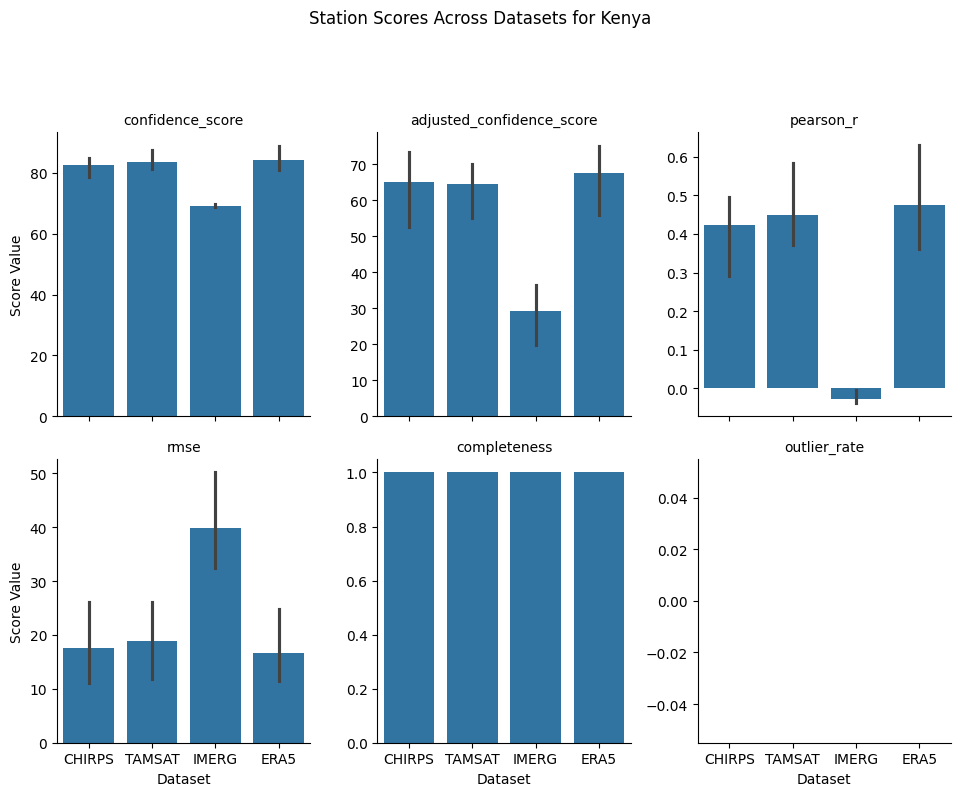

✅ Station scores comparison plot saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/station_scores_comparison_bar_Kenya.png


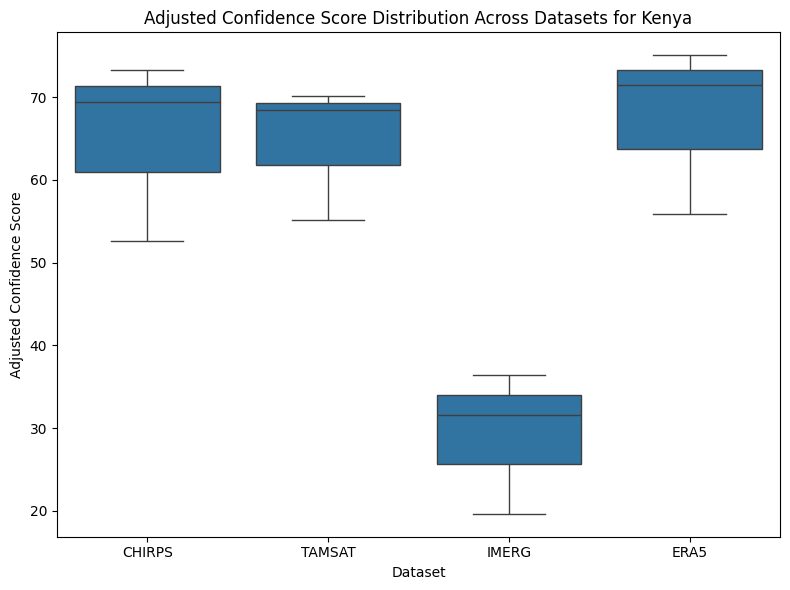

✅ Adjusted confidence score boxplot saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/adjusted_confidence_boxplot_Kenya.png


In [51]:
# @title Step 8: Visualize Station Scores Across Datasets {"display-mode":"form"}
# @markdown This step visualizes the computed station scores (confidence, RMSE, correlation, etc.) across the different satellite datasets.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Check if all_scores_dict is available and not empty
if 'all_scores_dict' in locals() and all_scores_dict:
    # Combine all scores into a single DataFrame
    all_scores_list = []
    for dataset_name, scores_df in all_scores_dict.items():
        if scores_df is not None and not scores_df.empty:
            all_scores_list.append(scores_df)

    if all_scores_list:
        combined_scores_df = pd.concat(all_scores_list, ignore_index=True)

        print("Combined Station Scores across Datasets:")
        display(combined_scores_df)

        # Define the output file path for combined scores
        combined_scores_output_path = os.path.join(RESULTS_DIR, f'combined_station_scores_{COUNTRY}.csv')
        combined_scores_df.to_csv(combined_scores_output_path, index=False)
        print(f"✅ Combined station scores saved to {combined_scores_output_path}")


        # --- Visualization ---

        # Melt the DataFrame for easier plotting of different metrics
        # Exclude 'p_value' and 'bias_signif' for melting as they are not numerical metrics for this type of plot
        metrics_to_plot = ['confidence_score', 'adjusted_confidence_score', f'{CORR_METHOD}_r', 'rmse', 'completeness', 'outlier_rate']
        metrics_to_plot = [metric for metric in metrics_to_plot if metric in combined_scores_df.columns] # Ensure metrics exist

        if metrics_to_plot:
            melted_scores_df = combined_scores_df.melt(
                id_vars=['station_id', 'dataset'],
                value_vars=metrics_to_plot,
                var_name='metric',
                value_name='score_value'
            )

            print("\nGenerating visualizations...")

            # Plotting each metric for each station across datasets
            g = sns.catplot(
                data=melted_scores_df,
                x='dataset',
                y='score_value',
                col='metric',
                kind='bar',
                sharey=False,
                col_wrap=3,
                height=4,
                aspect=0.8
            )
            g.fig.suptitle(f'Station Scores Across Datasets for {COUNTRY}', y=1.02)
            g.set_titles("{col_name}")
            g.set_axis_labels("Dataset", "Score Value")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plot_output_path = os.path.join(RESULTS_DIR, f'station_scores_comparison_bar_{COUNTRY}.png')
            plt.savefig(plot_output_path)
            plt.show()
            print(f"✅ Station scores comparison plot saved to {plot_output_path}")

             # Optional: Plotting adjusted confidence score distribution using box plot
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=combined_scores_df, x='dataset', y='adjusted_confidence_score')
            plt.title(f'Adjusted Confidence Score Distribution Across Datasets for {COUNTRY}')
            plt.xlabel('Dataset')
            plt.ylabel('Adjusted Confidence Score')
            plt.tight_layout()
            boxplot_output_path = os.path.join(RESULTS_DIR, f'adjusted_confidence_boxplot_{COUNTRY}.png')
            plt.savefig(boxplot_output_path)
            plt.show()
            print(f"✅ Adjusted confidence score boxplot saved to {boxplot_output_path}")


        else:
            print("⚠️ No suitable numerical metrics found to plot.")

    else:
        print("⚠️ No scores available in all_scores_dict to combine.")
else:
    print('⚠️ Station scores data (all_scores_dict) not available. Run Step 10a first.')

##**Step 9: Case study**

**Kenya Mai Mahiu Flash Flood:**
The Mai Mahiu flash flood occurred on April 29, 2024, in Nakuru County, Kenya. It was a devastating debris flow event triggered by heavy rainfall amid the broader 2024 Kenya floods. The incident resulted in significant casualties, injuries, and displacement, primarily affecting villages near Mai Mahiu town. Initially misreported as a dam burst (e.g., the Old Kijabe Dam), it was later confirmed as a blockage in a railway culvert causing a sudden release of water, mud, and debris. This event highlighted vulnerabilities in the Great Rift Valley due to steep terrain, deforestation, and soil erosion. The specified event window (April 20–May 5, 2024) captures the rainfall buildup and immediate aftermath.

**Rwanda Western & Northern Provinces Floods:**
The Western and Northern Provinces floods occurred on May 2-3, 2023, in Rwanda, triggered by heavy rainfall during the March-May wet season. This disaster involved severe flooding, mudslides, and landslides, causing widespread destruction in the Western, Northern, and Southern Provinces. The hardest-hit areas were in the Western Province near Lake Kivu, with significant impacts along rivers like Mukungwa. Initial misreports evolved into confirmed counts of massive loss, highlighting vulnerabilities in hilly, densely populated regions. The event window (May 1–8, 2023) encompassed the peak rains (110-130 mm in affected areas) and early response. It was part of broader East African flooding patterns, potentially amplified by climate change.

**Uganda Mbale-Kapchorwa Floods:**
The Mbale-Kapchorwa floods occurred on July 30, 2022, in the Eastern Region of Uganda, triggered by heavy rainfall amid the region's wet season. This event involved flash floods, river overflows, and landslides, resulting in significant casualties, displacement, and infrastructure damage. The floods were caused by approximately 10 hours of continuous heavy rain on the slopes of Mount Elgon, leading to the overflow of rivers such as Nabuyonga, Namatala, Nashibiso, and Napwoli. The most affected districts included Mbale, Kapchorwa, Sironko, Bulambuli, Bukedea, Butaleja, and Bududa. Initial reports indicated catastrophic damage to homes, schools, roads, and farmlands, exacerbating vulnerabilities in an area prone to such hazards due to steep terrain and deforestation. The event window (July 28–August 2, 2022) captured the peak rainfall and immediate impacts, with forecasts predicting continued enhanced rains into August.

More information related to the evet can be find in the workshop practical guide


In [52]:
# @title 9a) Visualize Event Location, Radius, and Stations on a Map {"display-mode":"form"}
# @markdown This step visualizes the selected case study event location, the radius around it from values defined at the start of the notebook, and the ground stations on a map.

import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import display, HTML # Import HTML for centering

radius = Radius_event*1000
# Set map dimensions
map_height = 500
map_width = 800

if COUNTRY=='Kenya':
  event_key = 'Kenya – Mai Mahiu flash flood (2024-04-29)'
elif COUNTRY=='Uganda':
  event_key = 'Uganda – Mbale–Kapchorwa floods (2022-07-30)'
elif COUNTRY=='Rwanda':
  event_key = 'Rwanda – Western/Northern floods (2023-05-02)'
else:
    event_key = None # Handle cases where country is not in the list

if event_key and event_key in EVENTS and 'coords' in EVENTS[event_key]:
    event_coords = EVENTS[event_key]['coords']
elif event_key and event_key not in EVENTS:
     print(f"⚠️ Event key '{event_key}' not found in EVENTS dictionary.")
elif event_key and 'coords' not in EVENTS[event_key]:
     print(f"⚠️ 'coords' key not found for event '{event_key}' in EVENTS dictionary.")


if event_coords is None:
    print(f"⚠️ Could not determine event coordinates for {COUNTRY}.")
elif df_gt is None or df_gt.empty:
    print('⚠️ Ground data not loaded or is empty. Cannot plot stations.')
else:
    event_lat, event_lon = event_coords

    # Filter stations to include only those with valid lat/lon and for the selected country
    # Assuming df_gt already contains data for the selected country based on the notebook setup
    stations_to_plot = df_gt.dropna(subset=['lat', 'lon']).drop_duplicates(subset=['station_id'])

    if stations_to_plot.empty:
        print(f"⚠️ No valid station locations found for {COUNTRY}. Cannot create map with stations.")
        # Create a map centered only on the event if no stations are available
        m = folium.Map(location=[event_lat, event_lon], zoom_start=12, tiles='OpenStreetMap', height=map_height, width=map_width) # Set height and width
    else:
        # Calculate the bounding box
        min_lat = min(stations_to_plot['lat'].min(), event_lat)
        max_lat = max(stations_to_plot['lat'].max(), event_lat)
        min_lon = min(stations_to_plot['lon'].min(), event_lon)
        max_lon = max(stations_to_plot['lon'].max(), event_lon)

        # Create a map with specified height and width
        m = folium.Map(tiles='OpenStreetMap', height=map_height, width=map_width) # Set height and width

        # Fit the map to the bounding box
        m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])


    # Add a marker for the event location
    folium.Marker([event_lat, event_lon], tooltip=event_key).add_to(m)

    # Add a circle with a 1km radius (approximately 0.009 degrees latitude/longitude)
    # Note: This is a rough approximation for visualization purposes. For accurate distance calculations,
    # use a proper library like geopy or pyproj.
    folium.Circle(
        location=[event_lat, event_lon],
        radius=radius,  # Radius in meters
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2,
        tooltip=f'{Radius_event}km radius'
    ).add_to(m)

    # Add markers for ground stations if available
    if not stations_to_plot.empty:
        for idx, row in stations_to_plot.iterrows():
            folium.CircleMarker(
                location=[row['lat'], row['lon']],
                radius=3,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.6,
                tooltip=row['station_id']
            ).add_to(m)
    print(f'Plotting {Radius_event}km radius of event')
    # Display the map centered using HTML and set the container height, adding a margin to the left
    display(HTML(f'<div style="display: flex; justify-content: center; height: {map_height}px; margin-left: 100px;">{m._repr_html_()}</div>'))

Plotting 30km radius of event


Extracting pixels for CHIRPS around event location...
Extracting pixels for TAMSAT around event location...
Extracting pixels for IMERG around event location...
Extracting pixels for ERA5 around event location...

Generating combined time series plot for extracted satellite pixels...


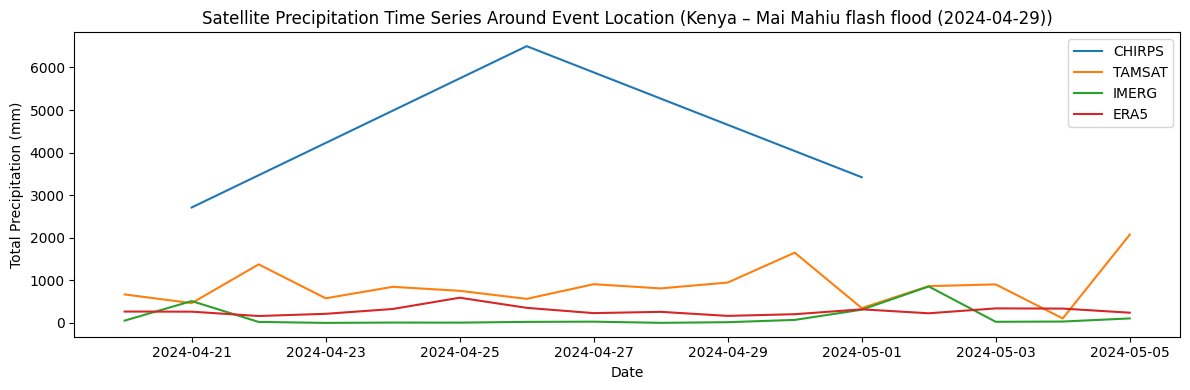

✅ Combined time series plot saved to /content/drive/MyDrive/Results_SkillExplorer_Kenya_2025-10-16/event_pixels_timeseries_combined.png


In [53]:
# @title 9b) Extract Satellite Precipitation Pixels Around Event Location and Plot Time Series {"display-mode":"form"}

# @markdown This cell extracts satellite precipitation data for pixels around the chosen event location within the specified neighborhood and generates a combined time series plot.

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np # Import numpy for nanmean

if COUNTRY=='Kenya':
  event_key = 'Kenya – Mai Mahiu flash flood (2024-04-29)'
elif COUNTRY=='Uganda':
  event_key = 'Uganda – Mbale–Kapchorwa floods (2022-07-30)'
elif COUNTRY=='Rwanda':
  event_key = 'Rwanda – Western/Northern floods (2023-05-02)'
else:
    event_key = None # Handle cases where country is not in the list

if event_key is None:
    print(f'⚠️ No case study defined for {COUNTRY}. Cannot extract satellite pixels around event.')
else:
    event_lat, event_lon = EVENTS[event_key]['coords']

    src={'CHIRPS':ds_chirps,'TAMSAT':ds_tamsat,'IMERG':ds_imerg,'ERA5':ds_era5}
    event_satellite_series = {} # Dictionary to store extracted time series (summed over neighborhood)

    # Determine the event date range for filtering and plotting
    if event_key in EVENTS and 'dates' in EVENTS[event_key]:
        start_evt_str, end_evt_str = EVENTS[event_key]['dates']
        start_evt,end_evt=[pd.to_datetime(x).tz_localize('UTC') for x in [start_evt_str, end_evt_str]] # Localize to UTC
    else:
        print("⚠️ Could not determine event date range for filtering.")
        start_evt, end_evt = None, None # Set to None if dates are not available


    for dataset_name, ds in src.items():
        if ds is not None:
            print(f"Extracting pixels for {dataset_name} around event location...")
            try:
                # Assuming the dataset has 'lat' and 'lon' or 'y' and 'x' dimensions
                if 'lat' in ds.coords and 'lon' in ds.coords:
                    lats = ds['lat'].values
                    lons = ds['lon'].values
                    lat_dim, lon_dim = 'lat', 'lon'
                elif 'y' in ds.coords and 'x' in ds.coords:
                    lats = ds['y'].values
                    lons = ds['x'].values
                    lat_dim, lon_dim = 'y', 'x'
                else:
                    print(f"⚠️ Could not find 'lat'/'lon' or 'y'/'x' dimensions in {dataset_name} dataset.")
                    continue

                # Find the nearest grid point
                lat_idx = np.abs(lats - event_lat).argmin()
                lon_idx = np.abs(lons - event_lon).argmin()

                # Extract data for the NEIGHBORHOOD nearest points
                lat_slice = slice(max(lat_idx - NEIGHBORHOOD // 2, 0), min(lat_idx + NEIGHBORHOOD // 2 + 1, len(lats)))
                lon_slice = slice(max(lon_idx - NEIGHBORHOOD // 2, 0), min(lon_idx + NEIGHBORHOOD // 2 + 1, len(lons)))

                sub_ds = ds.isel({lat_dim: lat_slice, lon_dim: lon_slice})

                # Select the precipitation variable
                precip_var = None
                for var in sub_ds.data_vars:
                    if 'precip' in var.lower() or 'rainfall' in var.lower() or 'precipitation' in var.lower() or 'rfe' in var.lower():
                         if (lat_dim in sub_ds[var].dims and lon_dim in sub_ds[var].dims and 'time' in sub_ds[var].dims):
                             precip_var = var
                             break
                if precip_var is None:
                     print(f"⚠️ Could not find a precipitation variable in {dataset_name}.")
                     continue

                # Sum precipitation across all pixels in the neighborhood for each time step
                # Ensure the time dimension is handled correctly before summing
                if 'time' in sub_ds[precip_var].dims:
                    # Handle potential NaN values when summing
                    time_series = sub_ds[precip_var].sum(dim=[lat_dim, lon_dim], skipna=False) # Keep NaN if all values are NaN
                    # Convert to pandas Series and store
                    event_satellite_series[dataset_name] = time_series.to_series()
                else:
                    print(f"⚠️ Time dimension not found in precipitation variable for {dataset_name}.")


            except Exception as e:
                print(f"Error extracting pixels for {dataset_name}: {e}")

    # --- Plotting ---
    if event_satellite_series:
        print("\nGenerating combined time series plot for extracted satellite pixels...")

        fig, ax = plt.subplots(figsize=(12, 4))

        # Plot each dataset's time series
        for dataset_name, series in event_satellite_series.items():
            if series is not None and not series.empty:
                 # Ensure the index is datetime and timezone-aware for plotting and slicing
                 if series.index.tzinfo is None:
                      series = series.tz_localize('UTC')
                 elif series.index.tzinfo != 'UTC':
                      series = series.tz_convert('UTC')

                 # Filter by event dates if available
                 if start_evt is not None and end_evt is not None:
                      series_filtered = series.loc[start_evt:end_evt].copy()
                 else:
                      series_filtered = series.copy() # Use all data if no event dates

                 if not series_filtered.empty:
                      ax.plot(series_filtered.index, series_filtered.values, label=dataset_name)
                 else:
                     print(f"ℹ️ No data available within the event date range for plotting {dataset_name}.")


        ax.set_title(f"Satellite Precipitation Time Series Around Event Location ({event_key})")
        ax.set_xlabel('Date')
        ax.set_ylabel('Total Precipitation (mm)')
        ax.legend()
        plt.tight_layout()

        # Save the plot
        plot_output_path = os.path.join(RESULTS_DIR, f'event_pixels_timeseries_combined.png')
        plt.savefig(plot_output_path)
        plt.show()
        print(f"✅ Combined time series plot saved to {plot_output_path}")

    else:
        print('⚠️ No satellite precipitation time series available for plotting.')